<a href="https://colab.research.google.com/github/Acharyaniyam/INFO-INFO212/blob/main/INFO213/INFO213_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# College of Computing and Informatics, Drexel University
## INFO 213: Data Science Programming II
---

## Project Title: Predictive Analytics on Supermarket Sales: Segmentation, Forecasting, and Satisfaction Modeling

## Student(s): Niyam Acharya

## Date: June 9, 2025
---

###Problem Definition

The goal of this project is to predict customer satisfaction ratings based on supermarket transaction data. Given structured data such as product type, customer demographics, pricing, and payment method, we aim to build a machine learning model that accurately estimates the "Rating" provided by customers. This involves exploring the relationships between various transaction-level features and customer satisfaction to identify meaningful predictors. The challenge lies in the fact that the dataset lacks direct feedback or behavioral indicators, making it difficult to infer subjective ratings from objective sales data.

###Loading and Understanding the Data

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/INFO213/SuperMarket Analysis.csv")

print(df.shape)
df.head()

(1000, 17)


,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Sales,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,Alex,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,1:08:00 PM,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,Giza,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29:00 AM,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,Alex,Yangon,Normal,Female,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,1:23:00 PM,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,Alex,Yangon,Member,Female,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,8:33:00 PM,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,Alex,Yangon,Member,Female,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37:00 AM,Ewallet,604.17,4.761905,30.2085,5.3


In [ ]:
#exloring the dataset
df.describe()


,Unit price,Quantity,Tax 5%,Sales,cogs,gross margin percentage,gross income,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1.000000e+03,1000.000000,1000.00000
mean,55.672130,5.510000,15.379369,322.966749,307.58738,4.761905e+00,15.379369,6.97270
std,26.494628,2.923431,11.708825,245.885335,234.17651,6.131498e-14,11.708825,1.71858
min,10.080000,1.000000,0.508500,10.678500,10.17000,4.761905e+00,0.508500,4.00000
25%,32.875000,3.000000,5.924875,124.422375,118.49750,4.761905e+00,5.924875,5.50000
50%,55.230000,5.000000,12.088000,253.848000,241.76000,4.761905e+00,12.088000,7.00000
75%,77.935000,8.000000,22.445250,471.350250,448.90500,4.761905e+00,22.445250,8.50000
max,99.960000,10.000000,49.650000,1042.650000,993.00000,4.761905e+00,49.650000,10.00000


In [ ]:
df.isnull().sum()

,0
Invoice ID,0
Branch,0
City,0
Customer type,0
Gender,0
Product line,0
Unit price,0
Quantity,0
Tax 5%,0
Sales,0


With no null and weird outliers, we can continue with the project

###Feature Selection

Numerical Data Correlation:

Rating                     1.000000
Unit price                -0.008778
Quantity                  -0.015815
cogs                      -0.036442
Tax 5%                    -0.036442
gross income              -0.036442
Sales                     -0.036442
gross margin percentage         NaN
Name: Rating, dtype: float64


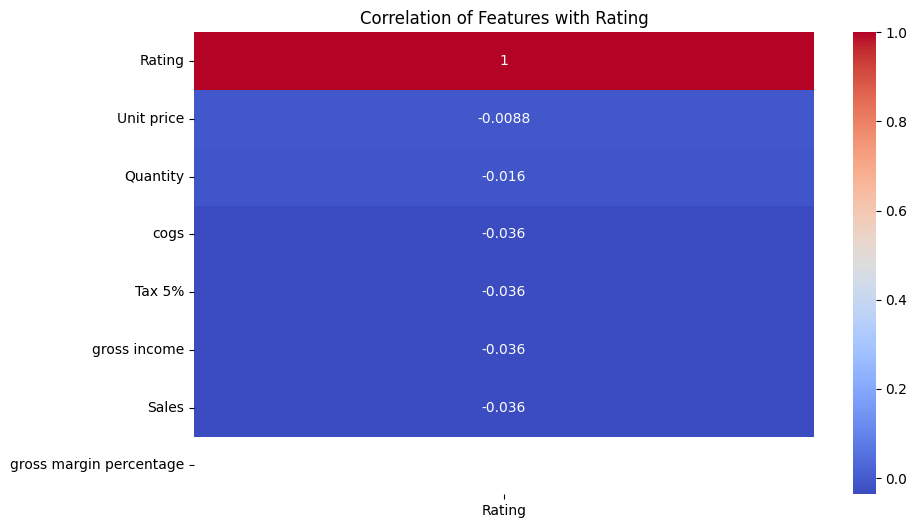

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get numerical columns only
numeric_cols = df.select_dtypes(include='number')

# Correlation matrix
corr = numeric_cols.corr()

# Show correlation with Rating
print(corr['Rating'].sort_values(ascending=False))

# Optional: visualize with heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr[['Rating']].sort_values(by='Rating', ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlation of Features with Rating")
plt.show()

The heatmap shows that individual numerical features such as unit price, quantity, and sales have very low linear correlation with the target variable, Rating. This suggests that simple linear relationships are weak, and more complex models or feature combinations may be needed to capture meaningful patterns in the data.

Categorical Data Correlation:

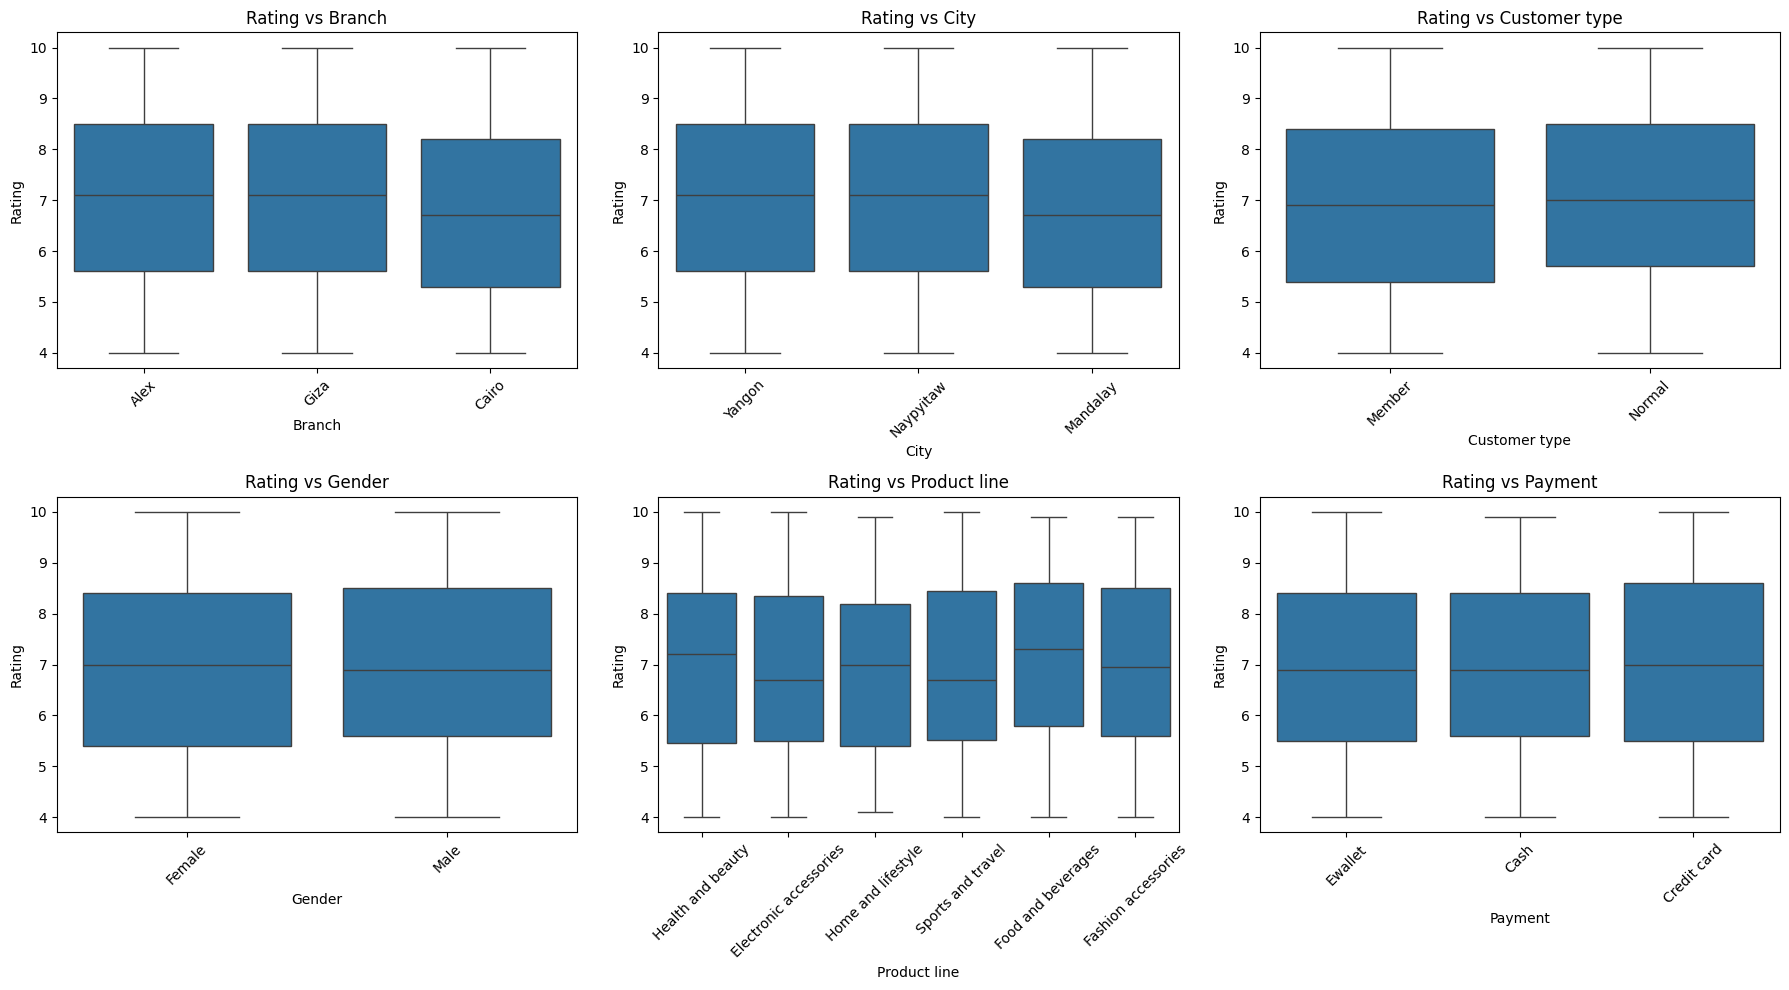

In [ ]:
categorical_cols = ['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Payment']

plt.figure(figsize=(18, 10
                  ))  # Wider canvas

for i, col in enumerate(categorical_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=col, y='Rating', data=df)
    plt.title(f'Rating vs {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

The boxplots show that categorical variables such as Branch, City, Customer type, and Payment method have similar rating distributions with overlapping interquartile ranges. This suggests that these features may not individually explain much variance in Rating, but could still be useful in combination with others in a predictive model.

###Feature Preprocessing

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Select relevant columns
X = df[['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Payment',
        'Unit price', 'Quantity', 'Tax 5%', 'Sales', 'cogs', 'gross income']]
y = df['Rating']

# Separate features
categorical_features = ['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Payment']
numerical_features = ['Unit price', 'Quantity', 'Tax 5%', 'Sales', 'cogs', 'gross income']

# Preprocessing by applying OneHotEncoder to Categorical Features and StandardScaler to All Features
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), categorical_features),
    ('scale', StandardScaler(), numerical_features)
])


For machine learning, the X values (i.e., the features) are determined by selecting a combination of categorical and numerical columns from the dataset and the y values are simply the df['Rating'] column.

###Feature Engineering / Dimensionality Reduction

In [ ]:
from sklearn.decomposition import PCA

# preprocessing
X_processed = preprocessor.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_pca = pca.fit_transform(X_processed)

# Retained Components
print(f"PCA reduced the data from {X_processed.shape[1]} to {X_pca.shape[1]} components.")

PCA reduced the data from 19 to 10 components.


###Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Define full pipeline: preprocessing + PCA
full_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('pca', PCA(n_components=0.95))
])

# Apply the pipeline to features
X_processed = full_pipeline.fit_transform(X)

# Now split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42)

In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (800, 10)
X_test shape: (200, 10)
y_train shape: (800,)
y_test shape: (200,)


###Training/Testing Machine Learning Models

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Decision Tree
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)

# Random Forest
forest = RandomForestRegressor(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)

# Polynomial Regression
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)


LinearRegression()

In [ ]:
#Testing each model:
# Predictions
#Linear Regression
y_pred_lin = lin_reg.predict(X_test)
#Decision Tree
y_pred_tree = tree.predict(X_test)
#Random Forest:
y_pred_forest = forest.predict(X_test)
#Polynomial regression:
X_test_poly = poly.transform(X_test)
y_pred_poly = poly_reg.predict(X_test_poly)

###Building Pipelines

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

# Base preprocessing steps
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), categorical_features),
    ('scale', StandardScaler(), numerical_features)
])

# Linear Regression Pipeline
pipe_lin = Pipeline([
    ('preprocess', preprocessor),
    ('pca', PCA(n_components=10)),
    ('model', LinearRegression())
])

# Decision Tree Pipeline
pipe_tree = Pipeline([
    ('preprocess', preprocessor),
    ('pca', PCA(n_components=10)),
    ('model', DecisionTreeRegressor(random_state=42))
])

# Random Forest Pipeline
pipe_forest = Pipeline([
    ('preprocess', preprocessor),
    ('pca', PCA(n_components=10)),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Polynomial Regression Pipeline
pipe_poly = Pipeline([
    ('preprocess', preprocessor),
    ('pca', PCA(n_components=10)),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LinearRegression())
])


Above I created pipelines for better organizing the end-to-end modeling steps into a single object that is easier to manage and cross-validate.

In [ ]:
pipe_lin

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Branch', 'City',
                                                   'Customer type', 'Gender',
                                                   'Product line', 'Payment']),
                                                 ('scale', StandardScaler(),
                                                  ['Unit price', 'Quantity',
                                                   'Tax 5%', 'Sales', 'cogs',
                                                   'gross income'])])),
                ('pca', PCA(n_components=10)), ('model', LinearRegression())])

In [ ]:
pipe_tree

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Branch', 'City',
                                                   'Customer type', 'Gender',
                                                   'Product line', 'Payment']),
                                                 ('scale', StandardScaler(),
                                                  ['Unit price', 'Quantity',
                                                   'Tax 5%', 'Sales', 'cogs',
                                                   'gross income'])])),
                ('pca', PCA(n_components=10)),
                ('model', DecisionTreeRegressor(random_state=42))])

In [ ]:
pipe_forest

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Branch', 'City',
                                                   'Customer type', 'Gender',
                                                   'Product line', 'Payment']),
                                                 ('scale', StandardScaler(),
                                                  ['Unit price', 'Quantity',
                                                   'Tax 5%', 'Sales', 'cogs',
                                                   'gross income'])])),
                ('pca', PCA(n_components=10)),
                ('model', RandomForestRegressor(random_state=42))])

In [ ]:
pipe_poly

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Branch', 'City',
                                                   'Customer type', 'Gender',
                                                   'Product line', 'Payment']),
                                                 ('scale', StandardScaler(),
                                                  ['Unit price', 'Quantity',
                                                   'Tax 5%', 'Sales', 'cogs',
                                                   'gross income'])])),
                ('pca', PCA(n_components=10)), ('poly', PolynomialFeatures()),
                ('model', LinearRegression())])

###Model Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define a function to evaluate and print results
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} \n-> RMSE: {rmse:.4f},\n R²: {r2:.4f}\n")

# Evaluate each model
evaluate_model("Linear Regression", y_test, y_pred_lin)
evaluate_model("Decision Tree", y_test, y_pred_tree)
evaluate_model("Random Forest", y_test, y_pred_forest)
evaluate_model("Polynomial Regression", y_test, y_pred_poly)


Linear Regression 
-> RMSE: 1.7576,
 R²: -0.0070

Decision Tree 
-> RMSE: 2.5577,
 R²: -1.1324

Random Forest 
-> RMSE: 1.8501,
 R²: -0.1158

Polynomial Regression 
-> RMSE: 1.8292,
 R²: -0.0906



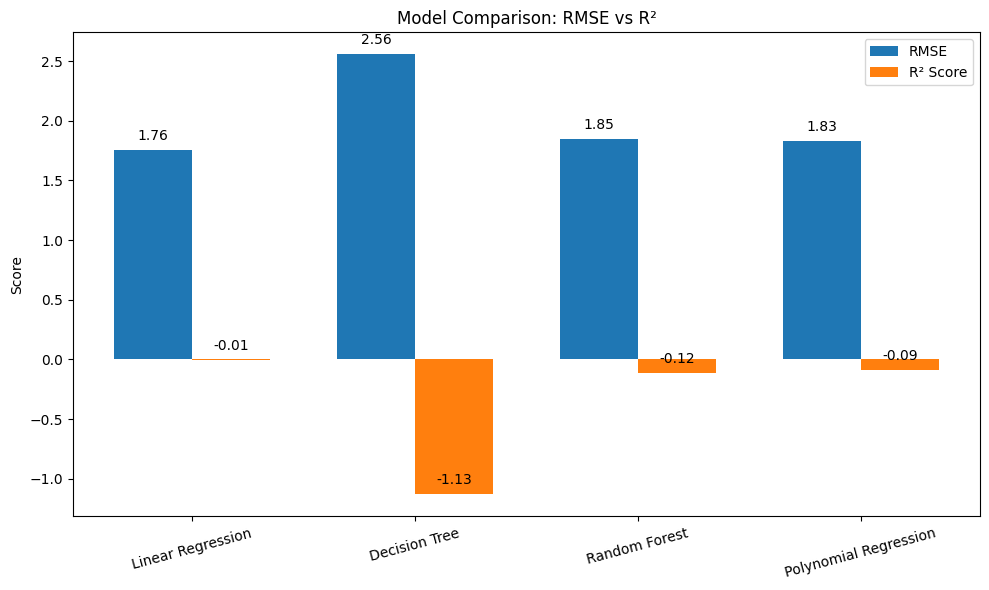

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics
model_names = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Polynomial Regression']
rmse_scores = [
    np.sqrt(mean_squared_error(y_test, y_pred_lin)),
    np.sqrt(mean_squared_error(y_test, y_pred_tree)),
    np.sqrt(mean_squared_error(y_test, y_pred_forest)),
    np.sqrt(mean_squared_error(y_test, y_pred_poly))
]
r2_scores = [
    r2_score(y_test, y_pred_lin),
    r2_score(y_test, y_pred_tree),
    r2_score(y_test, y_pred_forest),
    r2_score(y_test, y_pred_poly)
]

x = np.arange(len(model_names))
width = 0.35

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, rmse_scores, width, label='RMSE')
bars2 = ax.bar(x + width/2, r2_scores, width, label='R² Score')

# Labels
ax.set_ylabel('Score')
ax.set_title('Model Comparison: RMSE vs R²')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=15)
ax.legend()

# Annotate scores
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),  # offset text
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


The visualization shows that none of the models performed particularly well, as all R² scores are close to or below zero, indicating poor predictive power. Among them, Linear Regression had the lowest RMSE (1.76) and the least negative R² (-0.01), making it the best of the group, though still not ideal. Decision Tree performed the worst with both the highest RMSE (2.56) and a severely negative R² (-1.13), suggesting overfitting or poor generalization.

###Model Performance

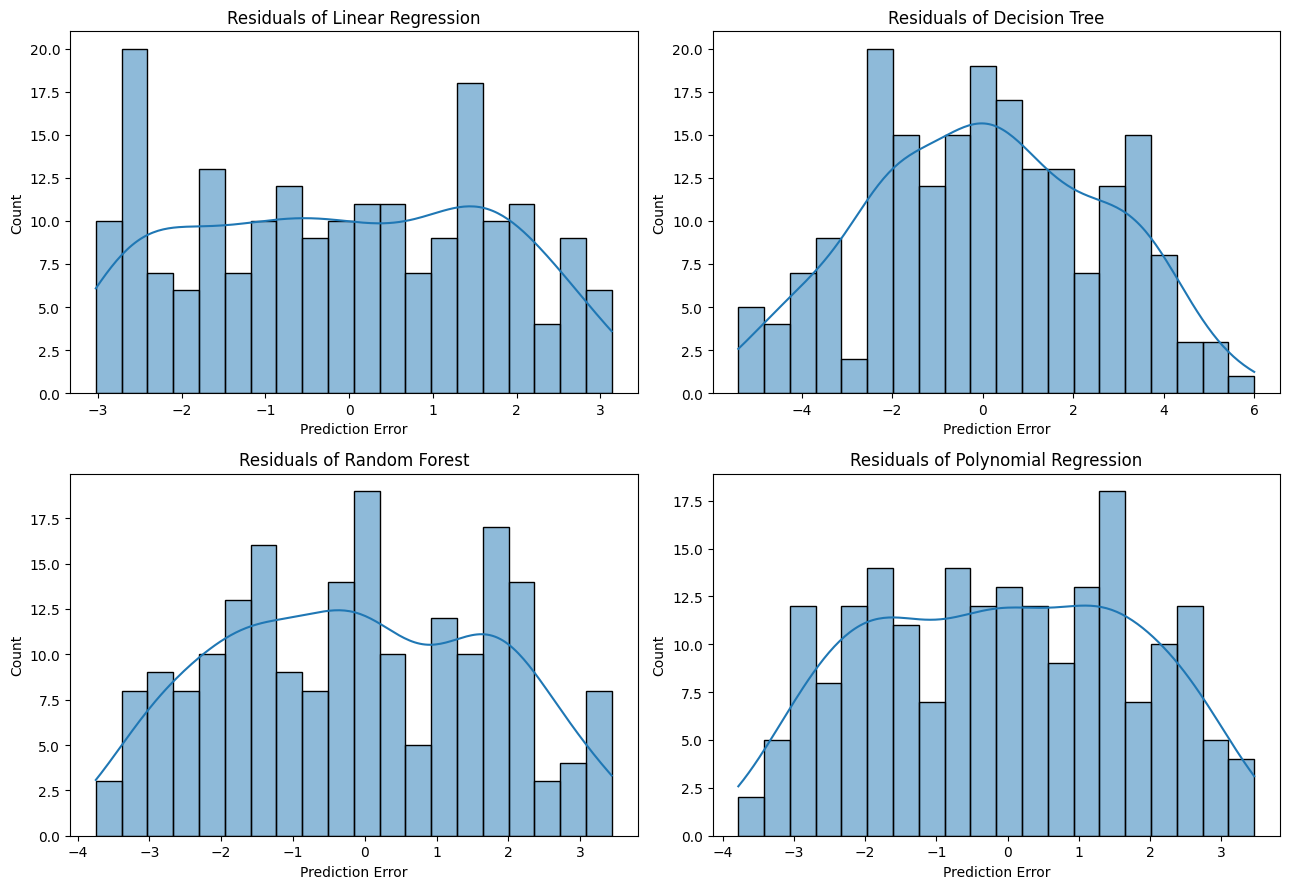

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals
residuals = {
    'Linear Regression': y_test - y_pred_lin,
    'Decision Tree': y_test - y_pred_tree,
    'Random Forest': y_test - y_pred_forest,
    'Polynomial Regression': y_test - y_pred_poly
}

# Plot residuals
plt.figure(figsize=(13, 9))
for i, (model, res) in enumerate(residuals.items(), 1):
    plt.subplot(2, 2, i)
    sns.histplot(res, kde=True, bins=20)
    plt.title(f"Residuals of {model}")
    plt.xlabel("Prediction Error")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

**Linear Regression**: The residuals are fairly spread out and show no clear pattern, but the distribution is not perfectly centered around zero, indicating some underfitting.

**Decision Tree**: The residuals are more widely spread and show a more erratic shape, suggesting the model is overfitting on some values and underperforming overall.

**Random Forest**: The residuals are better distributed than Decision Tree, but still have multiple peaks, which may indicate the model captures some non-linearity but struggles with rating variability.

**Polynomial Regression**: This model shows a reasonably symmetric distribution of residuals with reduced bias, but some overfitting is still evident in the spread and irregular density curve.

###Conclusion

In this project, we addressed the challenge of predicting customer satisfaction ratings using structured supermarket sales data. We approached the problem by building a machine learning pipeline that included preprocessing steps such as one-hot encoding, scaling, and PCA for dimensionality reduction. Several regression models—Linear Regression, Decision Tree, Random Forest, and Polynomial Regression—were trained and evaluated, but all demonstrated poor performance in predicting the target variable. This suggests that the available features do not strongly correlate with customer satisfaction and lack the depth needed to capture subjective customer sentiment. To improve results, future work could involve collecting richer data sources, such as textual customer reviews, or reframing the problem as a classification task to better align with how satisfaction ratings are typically interpreted.